In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

prng = np.random.RandomState(20250317)

%precision 3
pd.set_option('display.precision', 3)
np.set_printoptions(suppress=True, precision=3)

# Predict the demand for bike share using linear models

Our goal is to predict demand for bike share based on [this](https://www.kaggle.com/c/bike-sharing-demand) Kaggle task.
Kaggle provides two data sets: a labelled train data and an unlabelled test data.
We have to use the train data to predict labels for the test data. The data consists of hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month.
Kaggle won't give us the labels just a score we achieved on the test set.


### Know your data

In [2]:
bike_data = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2025/data/bike_sharing_demand/bike_sample.csv")
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-10-18T03:00:00Z,4,0,1,1,18.04,21.970,94,6.003,0,1,1
1,2011-08-17T21:00:00Z,3,0,1,1,29.52,34.090,62,15.001,38,192,230
2,2012-11-11T11:00:00Z,4,0,0,1,18.86,22.725,59,8.998,180,324,504
3,2011-05-12T16:00:00Z,2,0,1,2,26.24,31.060,57,16.998,50,238,288
4,2011-05-04T15:00:00Z,2,0,1,1,19.68,23.485,51,27.999,22,107,129


In [3]:
bike_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,2177.000,2177.000,2177.000,2177.000,2177.000,2177.000,2177.000,2177.000,2177.000,2177.000,2177.000
mean,2.537,0.029,0.685,1.434,20.250,23.611,62.011,13.021,36.555,155.789,192.344
std,1.120,0.168,0.465,0.643,7.786,8.445,19.285,8.150,51.005,151.047,181.464
min,1.000,0.000,0.000,1.000,0.820,2.275,0.000,0.000,0.000,0.000,1.000
25%,2.000,0.000,0.000,1.000,13.940,16.665,47.000,7.002,4.000,37.000,44.000
50%,3.000,0.000,1.000,1.000,20.500,24.240,62.000,12.998,17.000,120.000,147.000
75%,4.000,0.000,1.000,2.000,27.060,31.060,78.000,16.998,49.000,224.000,284.000
max,4.000,1.000,1.000,3.000,41.000,43.940,100.000,47.999,362.000,886.000,977.000


In [4]:
bike_data.shape

(2177, 12)

In [5]:
bike_data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

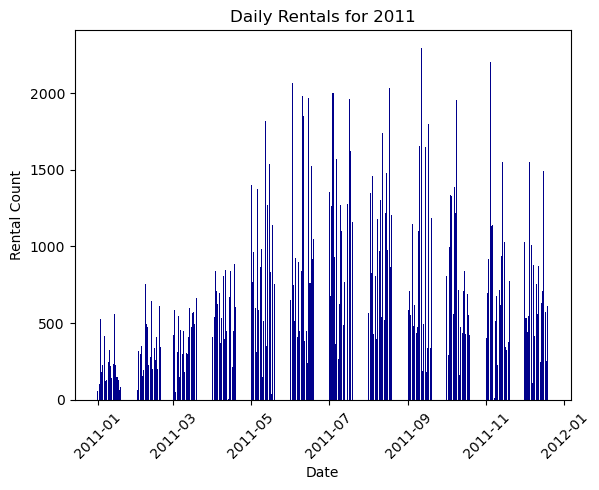

In [6]:
bike_data['datetime'] = pd.to_datetime(bike_data['datetime'])
bike_2011 = bike_data[bike_data['datetime'].dt.year == 2011]
daily_counts = bike_2011.groupby(bike_2011['datetime'].dt.date)['count'].sum()
dates = daily_counts.index
counts = daily_counts.values

plt.bar(dates, counts, color='darkblue')
plt.xlabel("Date")
plt.ylabel("Rental Count")
plt.title("Daily Rentals for 2011")
plt.xticks(rotation=45)
plt.show()

### Train-test split

In [7]:
# train-test split keeping numeric features

features = bike_data.drop(columns=['count']).select_dtypes(include=np.number)
label = bike_data['count']
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)

In [8]:
# choose a better train-test split

train_indices = pd.to_datetime(bike_data['datetime']).dt.day <= 15
X_train = features[train_indices]
X_test = features[~train_indices]
y_train = label[train_indices]
y_test = label[~train_indices]

print(f"Resulting size of the test is: {y_test.shape[0] / bike_data.shape[0]:.2%}")


Resulting size of the test is: 20.30%


### Evaluation function

**TODO**: Write a loss function that calculates the Root Mean Squared Log Error (RMSLE).

In [9]:
# define a loss function 
def calculateRMSLE(prediction, y_obs):
    return np.sqrt(np.mean(np.square(
        np.log(np.where(prediction < 0, 0, prediction) + 1) - np.log(y_obs + 1)
    )))

### Benchmark

**TODO**: Estimate a _very_ simple benchmark model (average), and evaluate its performance on both the train and the test set.

In [10]:
# estimate benchmark model
benchmark = np.mean(y_train)
print(f"Train error: {calculateRMSLE(benchmark, y_train):.2f}, Test error: {calculateRMSLE(benchmark, y_test):.2f}")

Train error: 1.56, Test error: 1.59


In [11]:
# Helper to keep track of the results
class ResultCollector:
    def __init__(self):
        self.results = {}
        
    def add_model(self, name, train_error, test_error):
        """Add or update a model's results."""
        self.results[name] = {
            'Train RMSLE': train_error,
            'Test RMSLE': test_error
        }
        return self.get_table()
    
    def get_table(self, style=True):
        """Get the results table with optional styling."""
        df = pd.DataFrame(self.results).T
        if style:
            return df.style.format("{:.3f}").background_gradient(cmap='RdYlGn_r', axis=None)
        return df

In [12]:
results = ResultCollector()
results.add_model("Benchmark", calculateRMSLE(benchmark, y_train), calculateRMSLE(benchmark, y_test))

,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588


### Model #1: Group averages

#### Statistics recap: linear regression and averages

If you fit a linear regression model using a **dummy variable** without any other features, the model will predict the average outcome for the groups represented by the dummy variables. A binary variable with numeric values 0 and 1 behaves as a dummy variable without any further transformation. The estimated intercept of the linear regression captures the average of the reference category (for which the binary variable takes the value of 0) while the coefficient expressed the difference between the averages of the categories.

In [13]:
# illustration on a single binary variable
lin_reg_simple_dummy = LinearRegression().fit(X_train[['holiday']], y_train)
prediction = lin_reg_simple_dummy.predict(X_train[['holiday']])

joint_data = pd.DataFrame({
    'dummy': X_train['holiday'].values,
    'y': y_train,
    'prediction': prediction
})
joint_data.groupby('dummy').agg({'y': 'mean', 'prediction': 'mean'})

,y,prediction
dummy,,
0,193.661,193.661
1,219.300,219.300


In [14]:
# Compare it to estimated coefficients
[lin_reg_simple_dummy.intercept_, lin_reg_simple_dummy.intercept_ + lin_reg_simple_dummy.coef_[0]]

[193.661, 219.300]

For a categorical variable with **multiple categories**, we have to ensure to represent each category level by a dummy variable (called one-hot encoding achieved by `pd.get_dummies()` or `OneHotEncoder`).
To avoid multicollinearity issues, you need to omit one of the dummy variables. Including all of them in the model would lead to redundant information because the value of one dummy variable can be predicted from the values of the other dummy variables. By omitting one dummy variable, you set it as the reference category, and the coefficients of the remaining dummy variables represent the difference in the outcome variable between each category and the reference category. With the constant term, you estimate as many coefficients as there are category levels.

In [15]:
# illustration on a multi-level categorical variable

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

lin_reg_multicategory_dummy = Pipeline([
    ('dummify', one_hot_encoder),
    ('ols', LinearRegression())
])

lin_reg_multicategory_dummy.fit(X_train[['season']], y_train)
prediction = lin_reg_multicategory_dummy.predict(X_train[['season']])

joint_data = pd.DataFrame({
    'season': X_train['season'].values,
    'y': y_train,
    'prediction': prediction
})

joint_data.groupby('season').agg({'y': 'mean', 'prediction': 'mean'})

,y,prediction
season,,
1,112.512,112.512
2,215.644,215.644
3,237.359,237.359
4,209.736,209.736


In [16]:
# check the data which is used for fitting
lin_reg_multicategory_dummy['dummify'].fit_transform(X_train[['season']])

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.]], shape=(1735, 3))

In [17]:
# Compare it to estimated coefficients
lm_model = lin_reg_multicategory_dummy['ols']
[lm_model.intercept_] + [lm_model.intercept_ + coef for coef in lm_model.coef_]

[112.512, 215.644, 237.359, 209.736]

If you have **multiple categorical variables**, life gets complicated. To ensure that you estimate as many coefficients as there are combinations of categories to capture the average of each group, we also need to include the _interaction_ of the dummies. You can achieve this with `PolynomialFeatures`. 

In [18]:
# Illustration on multiple categorical variables

create_interactions = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

lin_reg_complex_dummies =Pipeline([
    ('dummify', one_hot_encoder),
    ('create_interactions', create_interactions),
    ('ols', LinearRegression())
])

lin_reg_complex_dummies.fit(X_train[['season', 'workingday']], y_train)
prediction = lin_reg_complex_dummies.predict(X_train[['season', 'workingday']])

joint_data = pd.concat([
    X_train[['season', 'workingday']],
    pd.DataFrame({
        'y': y_train,
        'prediction': prediction
    })
], axis=1)
joint_data.groupby(['workingday', 'season']).agg({'y': 'mean', 'prediction': 'mean'})

y  prediction
workingday season                     
0          1        93.800      93.800
           2       228.434     228.434
           3       245.709     245.709
           4       204.262     204.262
1          1       118.749     118.749
           2       209.728     209.728
           3       232.865     232.865
           4       212.636     212.636

It indeed predicts group averages.

In [19]:
# We have more coefficients than the number of combinations of categories -- some of the coffients are zero (the overall effect is the same as the intercept)
[lin_reg_complex_dummies['ols'].intercept_] + [lin_reg_complex_dummies['ols'].intercept_ + coef for coef in lin_reg_complex_dummies['ols'].coef_]


[93.800,
 228.434,
 245.709,
 204.262,
 118.749,
 93.800,
 93.800,
 50.145,
 93.800,
 56.007,
 77.224]


However, if some of your categorical variables are multilevel, the interaction of these dummies within the same category (e.g. `season_2 * season_3`) will be constant zero, and you will get a linearly-dependent (rank-deficient) feature matrix. The optimization algorithm of the `LinearRegression` will give you a solution anyway estimating 0-s for the corresponding coefficients. It might be better to exclude variables with zero variance right away using the `VarianceThreshold` method (which defaults to the threshold of zero variance).

In [20]:
lin_reg_complex_dummies = Pipeline([
    ('dummify', one_hot_encoder),
    ('create_interactions', create_interactions),
    ('drop_zero_variance', VarianceThreshold()),
    ('ols', LinearRegression())
])

lin_reg_complex_dummies.fit(X_train[['season', 'workingday']], y_train)
prediction = lin_reg_complex_dummies.predict(X_train[['season', 'workingday']])

joint_data = pd.concat([
    X_train[['season', 'workingday']],
    pd.DataFrame({
        'y': y_train,
        'prediction': prediction
    })
], axis=1)
joint_data.groupby(['workingday', 'season']).agg({'y': 'mean', 'prediction': 'mean'})

y  prediction
workingday season                     
0          1        93.800      93.800
           2       228.434     228.434
           3       245.709     245.709
           4       204.262     204.262
1          1       118.749     118.749
           2       209.728     209.728
           3       232.865     232.865
           4       212.636     212.636

#### Technical detour: feature transformation within Pipeline

If you want to apply specific transformations on some columns, you can use `ColumnTransformer`. A `ColumnTransformer` takes a list of transformation and some optional parameters (like what to do with the `remainder` columns that were not specified in the transformation steps; defaults to `"drop"`, change to `"passthrough"` if you want to keep them). Each transformation consists of a three-element tuple: a name (you name it), the operation, and the columns the operation needs to be applied (given by the list of name, indices, etc.).

While `Pipeline` executes the steps sequentially, `ColumnTransformer` applies the listed operations at once on different sets of columns.

See [this Medium post](https://towardsdatascience.com/simplifying-machine-learning-model-development-with-columntransformer-pipeline-f09ffb04ca6b) for a more detailed explanation.

Here we would like to apply multiple steps sequentially on a specific set of the original columns in our training data, so we will pass a `Pipeline` to the `ColumnTransformer`. Then, we we would like to estimate a model, so we build another `Pipeline` for the whole process.

In [21]:
dummy_features = ["season", "workingday"]

one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
create_interactions = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

create_categorical_features = Pipeline([
    ("dummify", one_hot_encoder),
    ("create_interactions", create_interactions),
    ("drop_zero_variance", VarianceThreshold())
])

pipe_whole_process = Pipeline([
    ("create_features", ColumnTransformer([("choose_and_transform_features", create_categorical_features, dummy_features)])),
    ("ols", LinearRegression())
])
pipe_whole_process

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('choose_and_transform_features',
                                                  Pipeline(steps=[('dummify',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('create_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('drop_zero_variance',
                                                                   VarianceThreshold())]),
                                                  ['season', 'workingday'])])),
                ('ols', LinearRegression())])

In [22]:
pipe_whole_process.fit(X_train, y_train)  # note that we fit the whole X_train, not just the selected columns, as the ColumnTransformer will do the selection

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('choose_and_transform_features',
                                                  Pipeline(steps=[('dummify',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('create_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('drop_zero_variance',
                                                                   VarianceThreshold())]),
                                                  ['season', 'workingday'])])),
                ('ols', LinearRegression())])

In [23]:
pipe_whole_process["ols"].coef_

array([134.634, 151.909, 110.462,  24.949, -43.655, -37.793, -16.576])

In [24]:
# Double-check we got the same result
(
    calculateRMSLE(lin_reg_complex_dummies.predict(X_train[['season', 'workingday']]), y_train),
    calculateRMSLE(pipe_whole_process.predict(X_train), y_train),
)

(1.505, 1.505)

#### Estimate model #1: group averages by season, workingday and holiday

In [25]:
# estimate & evaluate model #1
dummy_features = ["season", "workingday", "holiday"]

steps = [
    ("create_features", ColumnTransformer([("choose_and_transform_features", create_categorical_features, dummy_features)])),
    ("ols", LinearRegression())
]

pipe_group_avg = Pipeline(steps)
pipe_group_avg.fit(X_train, y_train)


train_error = calculateRMSLE(pipe_group_avg.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_group_avg.predict(X_test), y_test)

results.add_model("Group averages", train_error, test_error)

,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588
Group averages,1.504,1.543


### Model #2: Group averages with weather

In [26]:
# Model #2: Group averages with weather
dummy_features = ['season', 'holiday', 'workingday', 'weather']
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed']

steps = [
    ("create_features", ColumnTransformer([
        ("choose_and_transform_dummy_features", create_categorical_features, dummy_features),
        ("keep_numeric_features", "passthrough", numeric_features)
    ])),
    ("ols", LinearRegression())
]

pipe_group_avg_with_weather = Pipeline(steps)
pipe_group_avg_with_weather.fit(X_train, y_train)

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('choose_and_transform_dummy_features',
                                                  Pipeline(steps=[('dummify',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('create_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('drop_zero_variance',
                                                                   VarianceThreshold())]),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('keep_numeric_features',
                                                  'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('ols', LinearRegression())])

In [27]:
results.add_model(
    'Group avgs with weather',
    calculateRMSLE(pipe_group_avg_with_weather.predict(X_train), y_train),
    calculateRMSLE(pipe_group_avg_with_weather.predict(X_test), y_test)
)

,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588
Group averages,1.504,1.543
Group avgs with weather,1.382,1.516


### Model #3: Very flexible linear with polynomial features

In [28]:
steps = [
    ("create_features", ColumnTransformer([
        ("create_dummy_features", one_hot_encoder, dummy_features), # we will create interactions later across all features
        ("keep_numeric_features", "passthrough", numeric_features)
    ])),
    ("4_degree_poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("drop_zero_variance", VarianceThreshold()),
    ("ols", LinearRegression())
]

pipe_flexible_linear = Pipeline(steps)
pipe_flexible_linear

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('create_dummy_features',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('keep_numeric_features',
                                                  'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('4_degree_poly',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('drop_zero_variance', VarianceThreshold()),
                ('ols', LinearRegression())])

In [29]:
pipe_flexible_linear.fit(X_train, y_train)
train_error = calculateRMSLE(pipe_flexible_linear.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_flexible_linear.predict(X_test), y_test)

results.add_model("Flexible linear", train_error, test_error)


,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588
Group averages,1.504,1.543
Group avgs with weather,1.382,1.516
Flexible linear,1.189,2.144


### Model #4: Improve with Lasso

**TODO**: Improve Model#3 by estimating a cross-validated Lasso on the expanded (flexible) dataset.

In [30]:
# Model #4: improve with Lasso
steps = [
    ("create_features", ColumnTransformer([
        ("create_dummy_features", one_hot_encoder, dummy_features), # we will create interactions later across all features
        ("keep_numeric_features", "passthrough", numeric_features)
    ])),
    ("4_degree_poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("drop_zero_variance", VarianceThreshold()),
    ("lasso", LassoCV())
]
pipe_lasso = Pipeline(steps)

pipe_lasso.fit(X_train, y_train)

/Users/divenyijanos/teaching/ceu-ml/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4741.977473966777, tolerance: 4624.063381556195
  model = cd_fast.enet_coordinate_descent_gram(
/Users/divenyijanos/teaching/ceu-ml/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5170.9758036360145, tolerance: 4624.063381556195
  model = cd_fast.enet_coordinate_descent_gram(
/Users/divenyijanos/teaching/ceu-ml/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5081.893979929388, tolerance: 4624.063381556195
  model = cd_fast.

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('create_dummy_features',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather']),
                                                 ('keep_numeric_features',
                                                  'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('4_degree_poly',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('drop_zero_variance', VarianceThreshold()),
                ('lasso', LassoCV())])

In [31]:
train_error = calculateRMSLE(pipe_lasso.predict(X_train), y_train)
test_error = calculateRMSLE(pipe_lasso.predict(X_test), y_test)

results.add_model("Flexible LASSO", train_error, test_error)

,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588
Group averages,1.504,1.543
Group avgs with weather,1.382,1.516
Flexible linear,1.189,2.144
Flexible LASSO,1.384,1.436


**Lessons:**

- Gradually adding more information present in the training improves our models' performance.
- Being very flexible without any penalty for the complexity leads to overfitting (test error >> train error).
- Choosing a method with regularization (and tune the hyperparameter automatically by `LassoCV`) is able to exploit flexibility without overfitting - however, the performance gain of flexibility is small.

## Improve the models

### Diagnostics

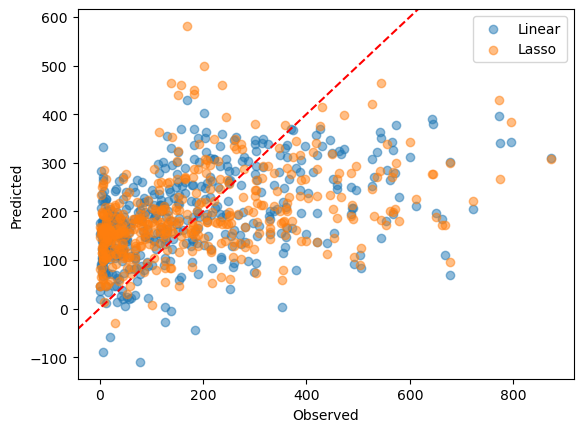

In [32]:
linear_predictions = pipe_group_avg_with_weather.predict(X_test)
lasso_predictions = pipe_lasso.predict(X_test)

plt.scatter(y_test, linear_predictions, label='Linear', alpha=0.5)
plt.scatter(y_test, lasso_predictions, label='Lasso', alpha=0.5)
plt.axline((1, 1), slope=1, linestyle='dashed', color='red')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend()

In [33]:
bike_data[bike_data['count'] < 5]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-10-18 03:00:00+00:00,4,0,1,1,18.04,21.970,94,6.003,0,1,1
16,2011-01-06 02:00:00+00:00,1,0,1,1,6.56,11.365,64,0.000,0,2,2
24,2011-04-14 03:00:00+00:00,2,0,1,1,13.94,16.665,81,8.998,0,2,2
61,2011-02-02 05:00:00+00:00,1,0,1,3,9.02,12.120,93,7.002,0,3,3
85,2011-03-07 04:00:00+00:00,1,0,1,1,8.20,7.575,80,35.001,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2055,2011-11-17 04:00:00+00:00,4,0,1,2,16.40,20.455,62,27.999,1,3,4
2063,2011-03-19 05:00:00+00:00,1,0,0,1,21.32,25.000,34,27.999,0,2,2
2099,2012-02-17 04:00:00+00:00,1,0,1,2,11.48,13.635,93,12.998,0,1,1
2123,2011-02-11 02:00:00+00:00,1,0,1,1,4.10,6.820,54,6.003,0,3,3


### Feature engineering

In [34]:
def extractDtFeatures(df_with_datetime):
    df_with_datetime['datetime'] = pd.to_datetime(df_with_datetime['datetime'], utc=True)
    df_with_datetime['year'] = df_with_datetime['datetime'].dt.year
    df_with_datetime['month'] = df_with_datetime['datetime'].dt.month
    df_with_datetime['hour'] = df_with_datetime['datetime'].dt.hour
    df_with_datetime['dayofweek'] = df_with_datetime['datetime'].dt.dayofweek


extractDtFeatures(bike_data)

In [35]:
feature_matrix = bike_data.drop(columns=["count", "registered", "casual"]).select_dtypes(include=np.number)

X_train_fe = feature_matrix[train_indices]
X_test_fe = feature_matrix[~train_indices]

#### Linear (FE)

We created many new categorical variables. Creating all the interactions would mean lots of parameters and we would be back in the "very flexible" scenario. Let's estimate a simpler linear model instead, where we only include the dummy variables but not their interactions.

In [36]:
dummy_features = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'hour', 'dayofweek']

steps = [
    ("create_features", ColumnTransformer([
        ("create_dummies", one_hot_encoder, dummy_features),
        ("keep_numeric_features", "passthrough", numeric_features)
    ])),
    ("ols", LinearRegression())
]

pipe_linear = Pipeline(steps)
pipe_linear.fit(X_train_fe, y_train)

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather',
                                                   'year', 'month', 'hour',
                                                   'dayofweek']),
                                                 ('keep_numeric_features',
                                                  'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('ols', LinearRegression())])

In [37]:
train_error = calculateRMSLE(pipe_linear.predict(X_train_fe), y_train)
test_error = calculateRMSLE(pipe_linear.predict(X_test_fe), y_test)

results.add_model("Feature engineered linear", train_error, test_error)


,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588
Group averages,1.504,1.543
Group avgs with weather,1.382,1.516
Flexible linear,1.189,2.144
Flexible LASSO,1.384,1.436
Feature engineered linear,1.100,1.201


#### Lasso (FE)

In [38]:
# Lasso
steps = [
    ("dummify_selected_columns", ColumnTransformer([
        ("dummify", one_hot_encoder, dummy_features),
        ("scale", StandardScaler(), numeric_features)
    ])),
    ("2_degree_poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lasso", LassoCV(random_state=prng, max_iter=10000))
]
pipe_lasso = Pipeline(steps)
pipe_lasso.fit(X_train_fe, y_train)

Pipeline(steps=[('dummify_selected_columns',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather',
                                                   'year', 'month', 'hour',
                                                   'dayofweek']),
                                                 ('scale', StandardScaler(),
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('2_degree_poly', PolynomialFeatures(include_bias=False)),
                ('lasso',
                 LassoCV(max_iter=10000,
                         random_state=RandomState(MT19937) at 0x302706840))])

In [39]:
train_error = calculateRMSLE(pipe_lasso.predict(X_train_fe), y_train)
test_error = calculateRMSLE(pipe_lasso.predict(X_test_fe), y_test)

results.add_model("Feature engineered Lasso", train_error, test_error)


,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588
Group averages,1.504,1.543
Group avgs with weather,1.382,1.516
Flexible linear,1.189,2.144
Flexible LASSO,1.384,1.436
Feature engineered linear,1.100,1.201
Feature engineered Lasso,0.693,0.841


**Lessons:**

- You should always look for more information hidden in your data.
- Extracting information hidden in the non-numeric `datetime` column resulted in a huge improvement for both OLS and Lasso.

### Collect more data

In [40]:
bike_full = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/train.csv")
bike_full.shape

(10886, 12)

In [41]:
bike_data.shape

(2177, 16)

In [42]:
# feature engineering
extractDtFeatures(bike_full)

In [43]:
bike_full.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
hour          0
dayofweek     0
dtype: int64

In [44]:
# We only want to change to train set so that the models could be compared on the same test set
full_data_train = bike_full[bike_full.datetime.dt.day <= 15]

In [45]:
X_full = full_data_train.drop(columns=['casual', 'registered', 'count'])
y_full = full_data_train['count']

In [46]:
X_full.shape, y_full.shape

((8600, 13), (8600,))

In [47]:
X_full.describe

<bound method NDFrame.describe of                        datetime  season  holiday  workingday  weather   temp  \
0     2011-01-01 00:00:00+00:00       1        0           0        1   9.84   
1     2011-01-01 01:00:00+00:00       1        0           0        1   9.02   
2     2011-01-01 02:00:00+00:00       1        0           0        1   9.02   
3     2011-01-01 03:00:00+00:00       1        0           0        1   9.84   
4     2011-01-01 04:00:00+00:00       1        0           0        1   9.84   
...                         ...     ...      ...         ...      ...    ...   
10785 2012-12-15 19:00:00+00:00       4        0           0        1  14.76   
10786 2012-12-15 20:00:00+00:00       4        0           0        2  14.76   
10787 2012-12-15 21:00:00+00:00       4        0           0        1  14.76   
10788 2012-12-15 22:00:00+00:00       4        0           0        1  14.76   
10789 2012-12-15 23:00:00+00:00       4        0           0        2  14.76   

     

#### Group averages with weather (full data)

In [48]:
pipe_group_avg_with_weather.fit(X_full, y_full)

train_error = calculateRMSLE(pipe_group_avg_with_weather.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_group_avg_with_weather.predict(X_test), y_test)

results.add_model("Group avgs with weather large n", train_error, test_error)


,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588
Group averages,1.504,1.543
Group avgs with weather,1.382,1.516
Flexible linear,1.189,2.144
Flexible LASSO,1.384,1.436
Feature engineered linear,1.100,1.201
Feature engineered Lasso,0.693,0.841
Group avgs with weather large n,1.419,1.523


#### Linear model (FE, full)

In [49]:
pipe_linear.fit(X_full, y_full)

Pipeline(steps=[('create_features',
                 ColumnTransformer(transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather',
                                                   'year', 'month', 'hour',
                                                   'dayofweek']),
                                                 ('keep_numeric_features',
                                                  'passthrough',
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('ols', LinearRegression())])

In [50]:
# evaluate
train_error = calculateRMSLE(pipe_linear.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_linear.predict(X_test_fe), y_test)

results.add_model("Feature engineered linear large n", train_error, test_error)


,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588
Group averages,1.504,1.543
Group avgs with weather,1.382,1.516
Flexible linear,1.189,2.144
Flexible LASSO,1.384,1.436
Feature engineered linear,1.100,1.201
Feature engineered Lasso,0.693,0.841
Group avgs with weather large n,1.419,1.523
Feature engineered linear large n,1.114,1.177


#### Lasso (FE, Full)

In [51]:
pipe_lasso.fit(X_full, y_full)

Pipeline(steps=[('dummify_selected_columns',
                 ColumnTransformer(transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['season', 'holiday',
                                                   'workingday', 'weather',
                                                   'year', 'month', 'hour',
                                                   'dayofweek']),
                                                 ('scale', StandardScaler(),
                                                  ['temp', 'atemp', 'humidity',
                                                   'windspeed'])])),
                ('2_degree_poly', PolynomialFeatures(include_bias=False)),
                ('lasso',
                 LassoCV(max_iter=10000,
                         random_state=RandomState(MT19937) at 0x302706840))])

In [52]:
# evaluate
train_error = calculateRMSLE(pipe_lasso.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_lasso.predict(X_test_fe), y_test)

results.add_model("Feature engineered Lasso large n", train_error, test_error)

,Train RMSLE,Test RMSLE
Benchmark,1.556,1.588
Group averages,1.504,1.543
Group avgs with weather,1.382,1.516
Flexible linear,1.189,2.144
Flexible LASSO,1.384,1.436
Feature engineered linear,1.100,1.201
Feature engineered Lasso,0.693,0.841
Group avgs with weather large n,1.419,1.523
Feature engineered linear large n,1.114,1.177
Feature engineered Lasso large n,0.768,0.818


**Lessons:**

- Collecting more samples from the same domain could help
- But only if the model is flexible enough to capture new (more subtle) patterns. A simple average is usually stable enough once you have 20 observations so collecting more won't have much impact. However, models that allow for complexity, such as the lasso on complex transformations, could benefit from the new set of training data.